In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# ========== Data Processing ==========
# Define tickers for diverse financial instruments
tickers = ['AAPL', 'TSLA', 'SPY', 'GLD', 'QQQ']

# Set date range (past 5 years)
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=4*365+366)

# Download historical market data
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# Handle missing values using forward-fill
data_filled = data.fillna(method='ffill')

# Verify data integrity
print("Missing values remaining:", data_filled.isnull().values.any())

[*********************100%***********************]  5 of 5 completed

Missing values remaining: False



/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_53968/924228541.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_filled = data.fillna(method='ffill')


In [2]:
# Extract closing prices
adj_close_prices = data_filled['Adj Close']

# ========== Feature Extraction ==========
# Trend Following Indicators
ma_short = adj_close_prices.rolling(window=20).mean()
ma_long = adj_close_prices.rolling(window=50).mean()

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

rsi = adj_close_prices.apply(compute_rsi)

# Mean Reversion Indicators
rolling_mean = adj_close_prices.rolling(window=20).mean()
rolling_std = adj_close_prices.rolling(window=20).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)
z_score = (adj_close_prices - rolling_mean) / rolling_std

# ========== Strategy Implementation ==========
# Trend Following Strategy
trend_signals = pd.DataFrame(index=adj_close_prices.index)

for ticker in tickers:
    # Entry signals
    trend_signals[ticker] = 0
    ma_crossover = (ma_short[ticker] > ma_long[ticker]) & (ma_short[ticker].shift(1) <= ma_long[ticker].shift(1))
    oversold = rsi[ticker] < 30
    trend_signals.loc[ma_crossover | oversold, ticker] = 1
    
    # Exit signals
    ma_crossunder = (ma_short[ticker] < ma_long[ticker]) & (ma_short[ticker].shift(1) >= ma_long[ticker].shift(1))
    overbought = rsi[ticker] > 70
    trend_signals.loc[ma_crossunder | overbought, ticker] = -1

# Mean Reversion Strategy
mean_reversion_signals = pd.DataFrame(index=adj_close_prices.index)

for ticker in tickers:
    # Entry signals
    mean_reversion_signals[ticker] = 0
    below_lower = adj_close_prices[ticker] < lower_band[ticker]
    z_undersold = z_score[ticker] < -1
    mean_reversion_signals.loc[below_lower | z_undersold, ticker] = 1
    
    # Exit signals
    above_upper = adj_close_prices[ticker] > upper_band[ticker]
    z_overbought = z_score[ticker] > 1
    mean_reversion_signals.loc[above_upper | z_overbought, ticker] = -1

# ========== Backtesting & Evaluation ==========
returns = adj_close_prices.pct_change()

def performance_metrics(strategy_signals, returns):
    strategy_returns = strategy_signals.shift(1) * returns
    strategy_returns = strategy_returns.fillna(0)
    
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    
    metrics = pd.DataFrame({
        'Annualized Return': strategy_returns.mean() * 252,
        'Annualized Volatility': strategy_returns.std() * np.sqrt(252),
        'Sharpe Ratio': (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252),
        'Max Drawdown': (cumulative_returns.cummax() - cumulative_returns).max()
    })
    
    return metrics

# Evaluate strategies
print("\nTrend Following Performance:")
print(performance_metrics(trend_signals, returns))


Trend Following Performance:
      Annualized Return  Annualized Volatility  Sharpe Ratio  Max Drawdown
AAPL          -0.018551               0.179423     -0.103394      0.381759
GLD            0.002320               0.081586      0.028441      0.141946
QQQ            0.099623               0.125213      0.795627      0.193212
SPY            0.075510               0.089612      0.842636      0.116271
TSLA          -0.217334               0.404514     -0.537271      0.860702


In [3]:
print("\nMean Reversion Performance:")
print(performance_metrics(mean_reversion_signals, returns))


Mean Reversion Performance:
      Annualized Return  Annualized Volatility  Sharpe Ratio  Max Drawdown
AAPL          -0.045862               0.222377     -0.206237      0.410885
GLD           -0.016829               0.113806     -0.147878      0.253381
QQQ            0.051339               0.176686      0.290568      0.227907
SPY            0.035857               0.131040      0.273631      0.178397
TSLA          -0.480990               0.499692     -0.962573      1.006552


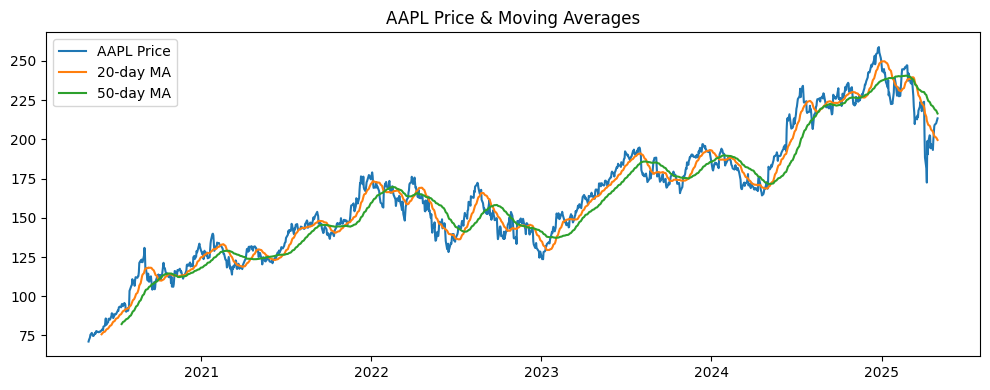

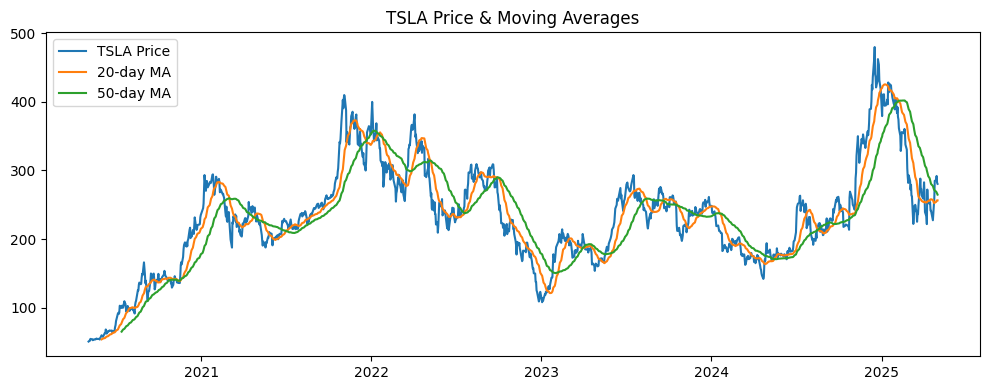

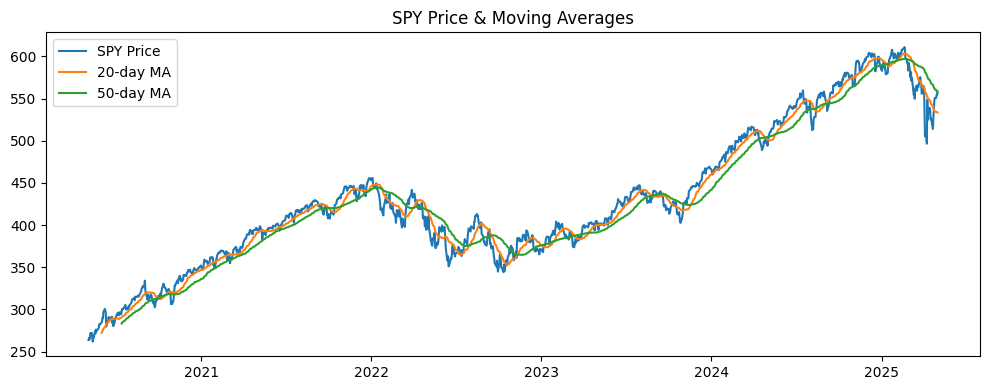

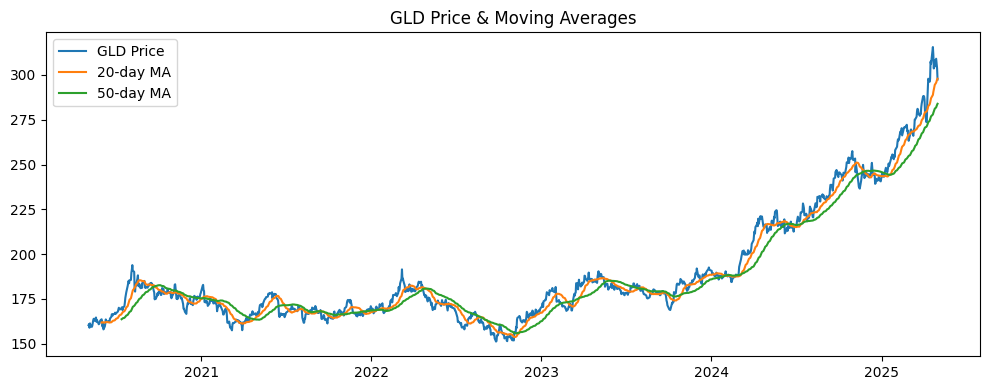

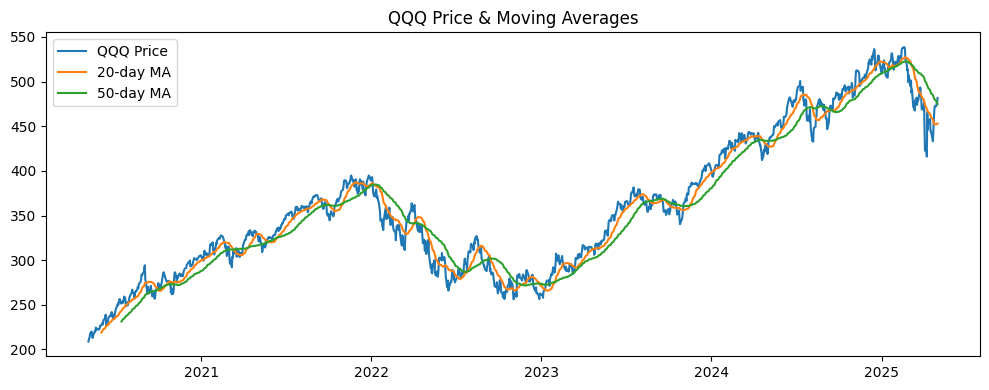

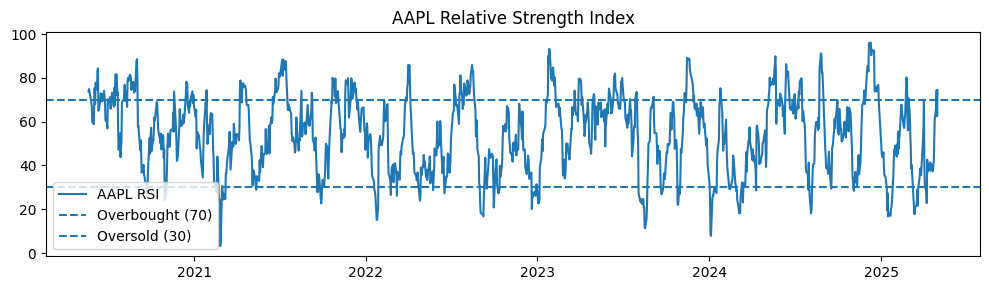

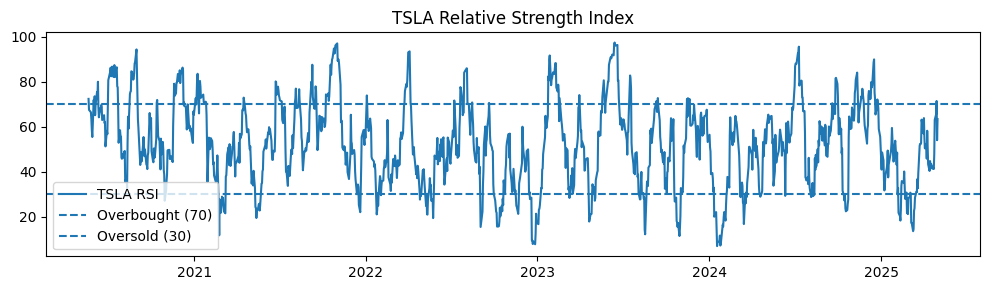

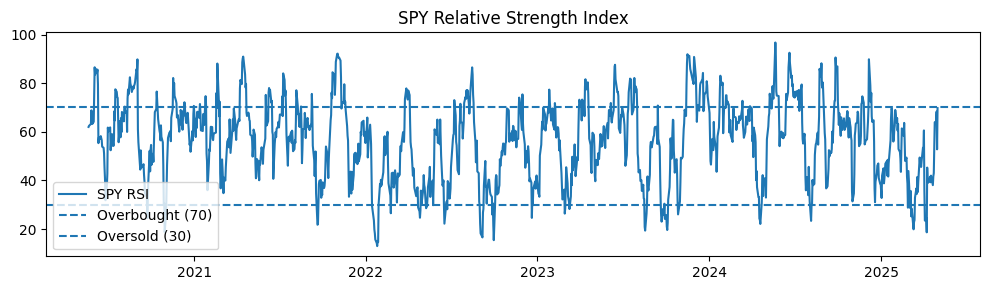

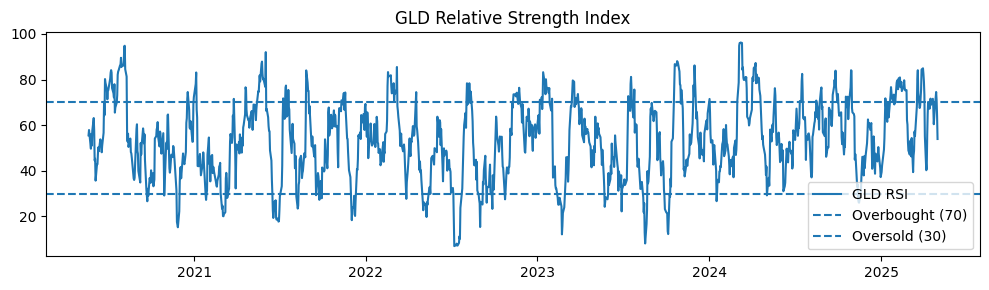

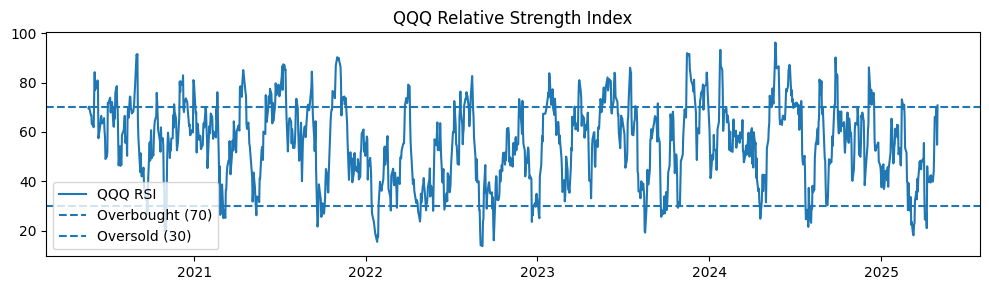

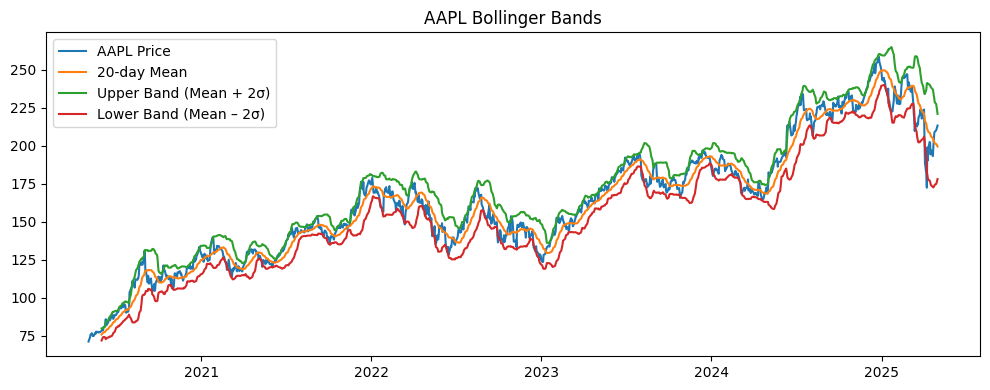

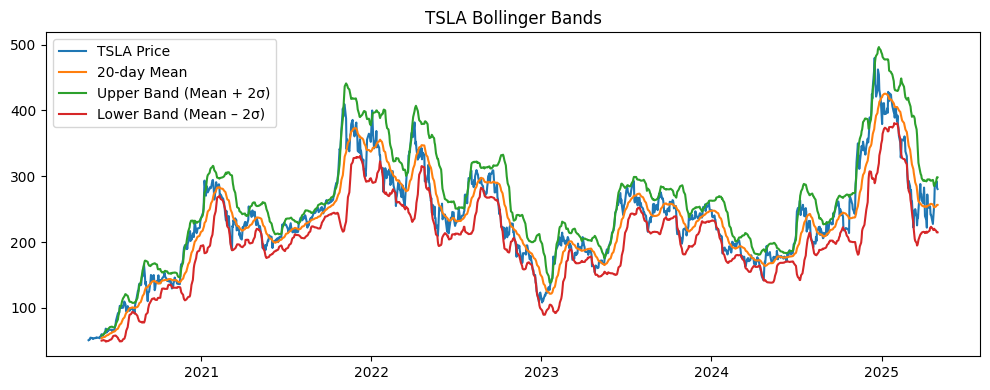

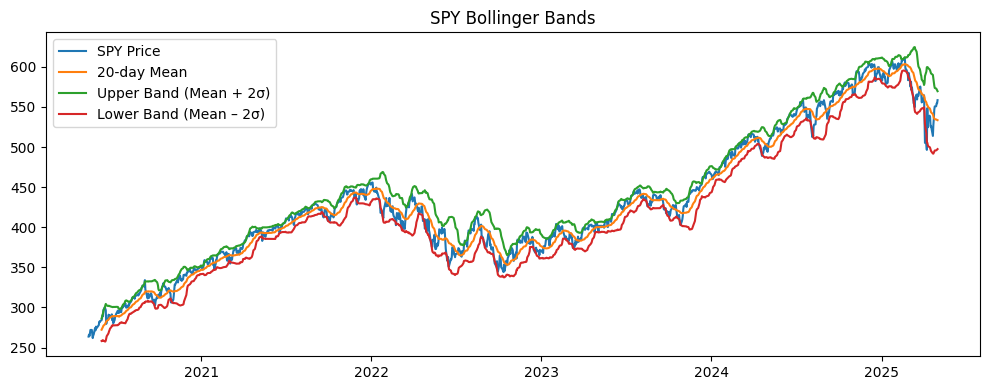

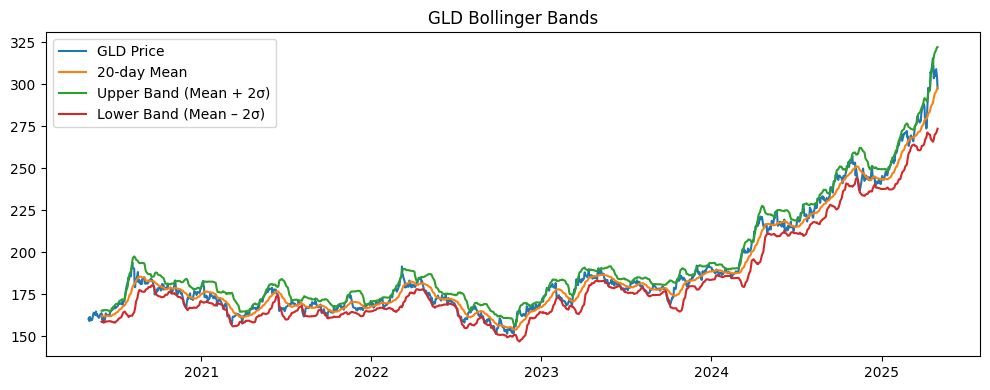

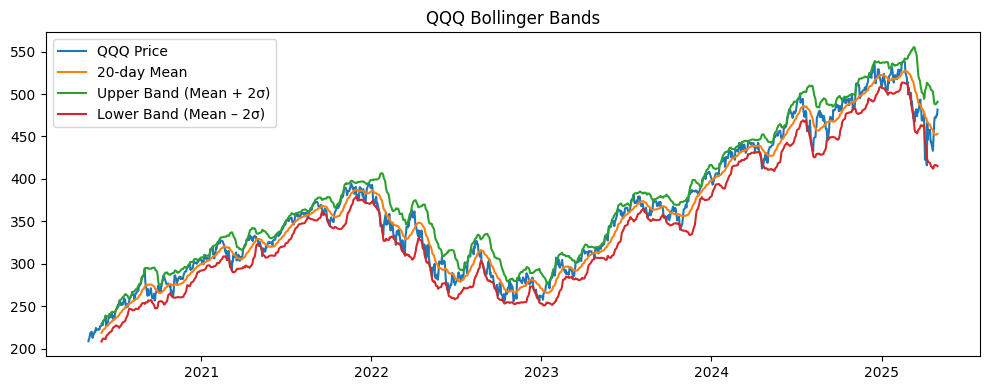

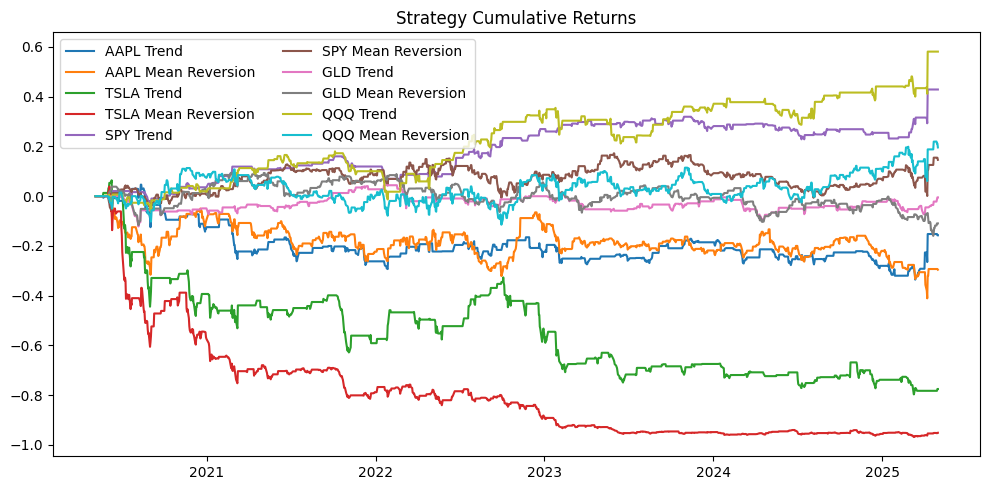

In [4]:
# 1. Price Series with Moving Averages
for ticker in tickers:
    plt.figure(figsize=(10, 4))
    plt.plot(adj_close_prices[ticker], label=f'{ticker} Price')
    plt.plot(ma_short[ticker],      label='20-day MA')
    plt.plot(ma_long[ticker],       label='50-day MA')
    plt.title(f'{ticker} Price & Moving Averages')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2. RSI with Overbought/Oversold Bands
for ticker in tickers:
    plt.figure(figsize=(10, 3))
    plt.plot(rsi[ticker], label=f'{ticker} RSI')
    plt.axhline(70, linestyle='--', label='Overbought (70)')
    plt.axhline(30, linestyle='--', label='Oversold (30)')
    plt.title(f'{ticker} Relative Strength Index')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3. Bollinger Bands
for ticker in tickers:
    plt.figure(figsize=(10, 4))
    plt.plot(adj_close_prices[ticker], label=f'{ticker} Price')
    plt.plot(rolling_mean[ticker],      label='20-day Mean')
    plt.plot(upper_band[ticker],        label='Upper Band (Mean + 2σ)')
    plt.plot(lower_band[ticker],        label='Lower Band (Mean – 2σ)')
    plt.title(f'{ticker} Bollinger Bands')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Cumulative Returns Comparison
# (re-compute inside plot scope for safety)
cum_trend = (1 + trend_signals.shift(1) * returns).cumprod() - 1
cum_mr    = (1 + mean_reversion_signals.shift(1) * returns).cumprod() - 1

plt.figure(figsize=(10, 5))
for ticker in tickers:
    plt.plot(cum_trend[ticker], label=f'{ticker} Trend')
    plt.plot(cum_mr[ticker],    label=f'{ticker} Mean Reversion')
plt.title('Strategy Cumulative Returns')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()